### Install Required Packages

In [ ]:
!pip install daam==0.0.11
!pip install accelerate  # this is to reduce CPU model load overhead
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 453 kB 10.4 MB/s 
     |████████████████████████████████| 13.8 MB 52.2 MB/s 
     |████████████████████████████████| 53 kB 843 kB/s 
     |████████████████████████████████| 5.5 MB 21.1 MB/s 
     |████████████████████████████████| 182 kB 63.0 MB/s 
     |████████████████████████████████| 7.6 MB 51.5 MB/s 
     |████████████████████████████████| 84 kB 2.3 MB/s 
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 106 kB 71.3 MB/s 
     |████████████████████████████████| 2.3 MB 65.8 MB/s 
     |████████████████████████████████| 278 kB 71.5 MB/s 
     |████████████████████████████████| 84 kB 4.8 MB/s 
     |████████████████████████████████| 64 kB 3.2 MB/s 
     |████████████████████████████████| 80 kB 9.9 MB/s 
     |████████████████████████████████| 68 k

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b28d3e60-eccf-9be6-edb5-54466c054ca9)


### Load Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [ ]:
import os

from matplotlib import pyplot as plt
import numpy as np

from PIL import Image
import cv2

from nltk.corpus import stopwords

from diffusers import StableDiffusionPipeline
import daam
import torch

Download the stopwords for removing stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Load Data

The below list is a placeholder for any list of prompts, we will be replacing it with a list of prompts from `MS-COCO` text annotations later.

In [ ]:
# prompts = [
#   "A group of people stand in the back of a truck filled with cotton.",
#   "A mother and three children collecting garbage from a blue and white garbage can on the street.",
#   "A woman is sitting in a chair reading a book with her head resting on her free hand.",
#   "A brown and white dog exiting a yellow and blue ramp in a grassy area.",
#   "A boy stands on a rocky mountain."
#   ]

prompts = [
  "A group of people stand in the back of a truck filled with cotton."
]

### Setting up the Pipeline

I will set up the pipeline for generation of the heatmaps for each generated image for each prompt in the `prompts` list. We will be generating $20$ images per prompt.

Below I summarising the storage scheme, I adopted:
- For $i^{th}$ prompt in `prompts` list create a folder named `i`.
- For $i^{th}$ prompt in the `prompts` list generate `NUM_IMAGES_PER_PROMPT` images from a diffusion model (`stabilityai/stable-diffusion-2-base`) and store each of these images in subfolders under `i`. So, if the generated images are named `a`, `b`, .., `t` then we will store them in folders in the following way: `i\1\Image\a.png`, .., `i\<NUM_IMAGES_PER_PROMPT>\Image\t.png`.
- Each of these `NUM_IMAGES_PER_PROMPT` subfolders, say `i\0\Heatmap` will store the heatmaps (as `.npy` files) for each image, where the number of heatmaps is equal to the number of tokens in that particular prompt minus the stopwords that generated these images and these heatmaps will be named as per the index of the word in the prompt that generated it.
- Each of these `NUM_IMAGES_PER_PROMPT` subfolders, say `i\0\BBox` will store bounding boxes (as `.npy` files) for each of the heatmap, where each of these bounding boxes file will be of the shape `#bboxes_after_NPM x 4` and the 4 columns correspond to:
  - x1: top-left x coordinate of a bounding box
  - y1: top-left y coordinate of a bounding box
  - x2: bottom-right x coordinate of a bounding box
  - y2: bottom-right y coordinate of a bounding box
- Similarly, each of these `NUM_IMAGES_PER_PROMPT` subfolders, say `i\0\BinThresh` will store the binary threshold (as `.npy` files)
- Similarly, each of these `NUM_IMAGES_PER_PROMPT` subfolders, say `i\0\Contour` will store the contour images (as `.npy` files)

#### Set some parameters

In [ ]:
NUM_IMAGES_PER_PROMPT = 2 # Number of images to be generated per prompt
NMS_OVERLAP_THRESHOLD = 0.7 # Non-Max Suppression Threshold beyond which the boxes will be merged

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [ ]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to('cuda')

Downloading:   0%|          | 0.00/511 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/308 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/738 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/716 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Let's generate Global Word Attribution HeatMaps.

In [ ]:
# The folder that will contain the generated data
os.mkdir('Data-Generated')

# Stopwords
stpwords = set(stopwords.words('english'))

In [ ]:
# Helper Function that performs Non-Max Suppression when given the bounding boxes and threshold in the format mentioned above for storing `.npy`
# Files in BBox
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap >= overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [ ]:
# Iterating overs the prompts
for i, prompt in enumerate(prompts):

  # Creating a folder for each prompt
  os.mkdir(f'Data-Generated/{i}')

  for j in range(NUM_IMAGES_PER_PROMPT):
    
    # Creating NUM_IMAGES_PER_PROMPT subfolders for each generated image
    os.mkdir(f'Data-Generated/{i}/{j}')

    # Generating images and storing their trace for daam output
    with daam.trace(model) as trc:
      output_image = model(prompt).images[0]
      global_heat_map = trc.compute_global_heat_map()

    # Creating folder to store the generated image and saving that
    os.mkdir(f'Data-Generated/{i}/{j}/Image')
    output_image.save(f'Data-Generated/{i}/{j}/Image/{chr(97+j)}.png')

    # Creating folder to save the heatmaps corresponding to each generated image
    os.mkdir(f'Data-Generated/{i}/{j}/Heatmap')
    # Creating folder to store the above binary threshold
    os.mkdir(f'Data-Generated/{i}/{j}/BinThresh')
    # Creating folder to store the above contours
    os.mkdir(f'Data-Generated/{i}/{j}/Contour')
    # Creating folder to store the above bboxes
    os.mkdir(f'Data-Generated/{i}/{j}/BBox')
    # Creating folder to store the above bboxes images
    os.mkdir(f'Data-Generated/{i}/{j}/BBoxImg')

    # Generate Global Word Attribution HeatMap
    for k, word in enumerate(prompt.split()):

      # Skip generating heatmap for stopwords
      if word in stpwords:
        continue
      
      # Compute heatmap for a non-stopword
      word_heatmap = global_heat_map.compute_word_heat_map(word).expand_as(output_image).numpy()

      # Saving heatmap
      np.save(f'Data-Generated/{i}/{j}/Heatmap/{k}.npy', word_heatmap)

      # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
      heatmap = np.array(word_heatmap * 255, dtype = np.uint8)

      # Binary threshold of the above heatmap - serves as sort of semantic segmentation for the word
      thresh = cv2.threshold(heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

      # Saving binary threshold
      np.save(f'Data-Generated/{i}/{j}/BinThresh/{k}.npy', thresh)

      # Find contours from the binary threshold
      cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = cnts[0] if len(cnts) == 2 else cnts[1]

      # Saving contours
      heatmap_temp = np.copy(heatmap)
      np.save(f'Data-Generated/{i}/{j}/Contour/{k}.npy', cv2.drawContours(heatmap_temp, cnts, -1, (255,0,0), 5))

      # Find bounding boxes from contours
      bboxes = np.zeros((len(cnts), 4))

      for idx, c in enumerate(cnts):
          x,y,w,h = cv2.boundingRect(c)
          bboxes[idx, :] = np.array([x,y, x+w, y+h])
      
      # Merge multiple box predictions using Non-Max Suppression
      bboxes = non_max_suppression_fast(bboxes, NMS_OVERLAP_THRESHOLD)
 
      # Saving bbox
      np.save(f'Data-Generated/{i}/{j}/BBox/{k}.npy', bboxes)

      # Putting the NMS Boxes
      heatmap_temp = np.copy(heatmap)
      for idx in range(bboxes.shape[0]):
        cv2.rectangle(heatmap_temp, (bboxes[idx, 0], bboxes[idx, 1]), (bboxes[idx, 2], bboxes[idx, 3]), (255,0,0), 2)
      
      # Saving nmsbbox
      np.save(f'Data-Generated/{i}/{j}/BBoxImg/{k}.npy', heatmap_temp)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

### Visualization of DAAM related outputs

Now that I have generated an arsenal of outputs for each generated image (where even the generated images are multiple for each prompt i.e. `NUM_IMAGES_PER_PROMPT`). Let's walk through these folders or files.

In [ ]:
from directory_tree import display_tree
display_tree('Data-Generated')


$ Operating System : Linux
$ Path : Data-Generated

*************** Directory Tree ***************

Data-Generated/
└── 0/
    ├── 0/
    │   ├── BBox/
    │   │   ├── 0.npy
    │   │   ├── 1.npy
    │   │   ├── 10.npy
    │   │   ├── 11.npy
    │   │   ├── 13.npy
    │   │   ├── 3.npy
    │   │   ├── 4.npy
    │   │   └── 7.npy
    │   ├── BBoxImg/
    │   │   ├── 0.npy
    │   │   ├── 1.npy
    │   │   ├── 10.npy
    │   │   ├── 11.npy
    │   │   ├── 13.npy
    │   │   ├── 3.npy
    │   │   ├── 4.npy
    │   │   └── 7.npy
    │   ├── BinThresh/
    │   │   ├── 0.npy
    │   │   ├── 1.npy
    │   │   ├── 10.npy
    │   │   ├── 11.npy
    │   │   ├── 13.npy
    │   │   ├── 3.npy
    │   │   ├── 4.npy
    │   │   └── 7.npy
    │   ├── Contour/
    │   │   ├── 0.npy
    │   │   ├── 1.npy
    │   │   ├── 10.npy
    │   │   ├── 11.npy
    │   │   ├── 13.npy
    │   │   ├── 3.npy
    │   │   ├── 4.npy
    │   │   └── 7.npy
    │   ├── Heatmap/
    │   │   ├── 0.npy
    │   │   ├── 1.npy
 

The images generated in `Image` folders are shown below

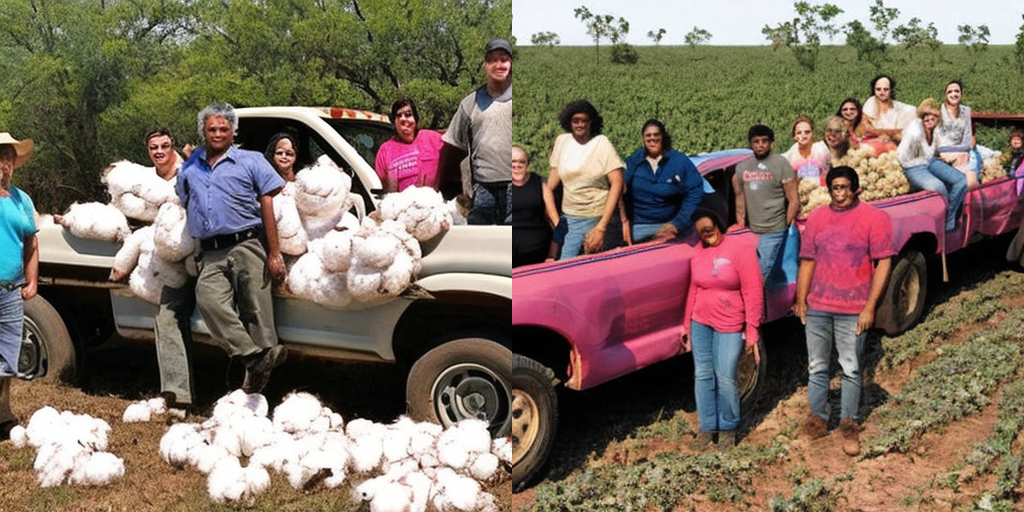

In [ ]:
def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  
  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

image_grid([Image.open('Data-Generated/0/0/Image/a.png'), Image.open('Data-Generated/0/1/Image/b.png')], 1, 2)

Let's visualize the global word attribution heatmaps for the tokens.

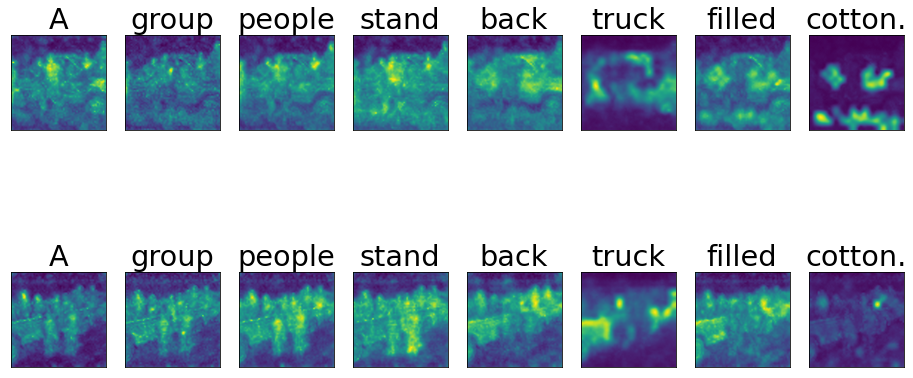

In [ ]:
def make_im_subplots(*args):
  fig, ax = plt.subplots(*args)

  for ax_ in ax.flatten():
    ax_.set_xticks([])
    ax_.set_yticks([])
  
  return fig, ax

def visualize(name):
  # I did not generalize this function yet to any number of images and more
  plt.rcParams['figure.figsize'] = (16, 8)
  fig, ax = make_im_subplots(2, 8)

  non_stp_words = sorted([int(f.split('.')[0]) for f in os.listdir('Data-Generated/0/0/Heatmap')])
  heatmap1 = os.listdir(f'Data-Generated/0/0/{name}')
  heatmap2 = os.listdir(f'Data-Generated/0/1/{name}')


  for i, idx in enumerate(non_stp_words):
    ax[0, i].imshow(np.load(f'Data-Generated/0/0/{name}/{idx}.npy'))
    ax[0, i].set_title(prompts[0].split()[idx])
    ax[1, i].imshow(np.load(f'Data-Generated/0/1/{name}/{idx}.npy'))
    ax[1, i].set_title(prompts[0].split()[idx])
  plt.show()

visualize('Heatmap')

Let's visualize the `BinThresh`

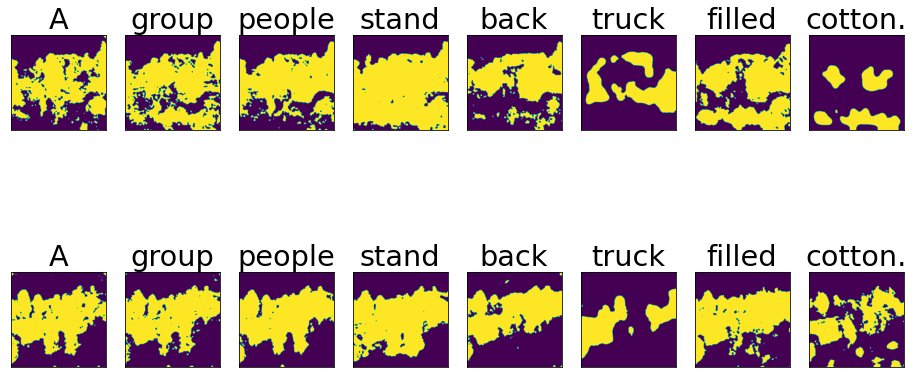

In [ ]:
visualize('BinThresh')

Let's visualize `Contour`

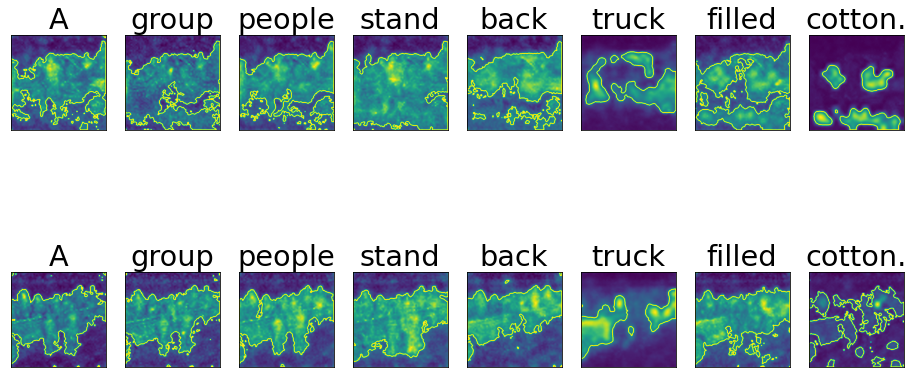

In [ ]:
visualize('Contour')

Let's visualize `BBoxImg`

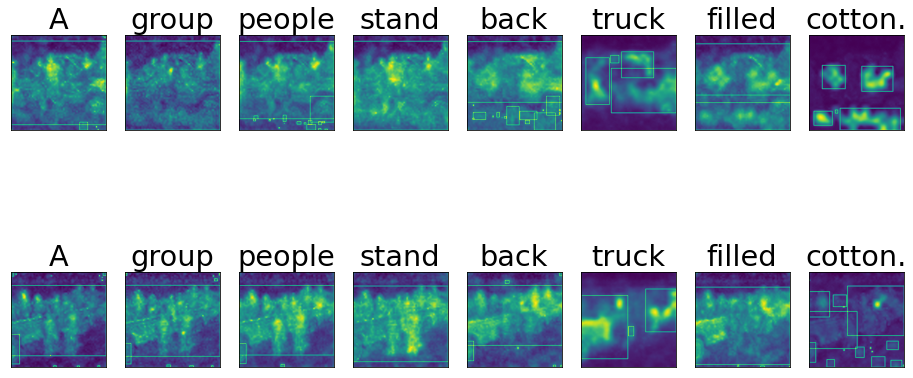

In [ ]:
visualize('BBoxImg')